# Shaft torque as a state

The conventional state-space model used in shaft-line FEM can be modified to have shaft torque as a state instead of node angles. Frist, the conventional state-space model for a 2-DOF system:

$$ \begin{bmatrix} \dot{\theta_1} \\ \dot{\theta_2} \\ \ddot{\theta}_1 \\ \ddot{\theta_2} \end{bmatrix} = \underbrace{\begin{bmatrix} \boldsymbol{0} & \textbf{I} \\ -\textbf{M}^{-1}\textbf{K} & -\textbf{M}^{-1}\textbf{C} \end{bmatrix}}_{\textbf{A}} \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta_2} \end{bmatrix} + \underbrace{\begin{bmatrix} \boldsymbol{0} \\ \textbf{M}^{-1} \end{bmatrix}}_{\textbf{B}} \begin{bmatrix} T_{\text{1}} \\ T_{\text{2}} \end{bmatrix} $$

where $\textbf{M}$, $\textbf{C}$, $\textbf{K}$ and $\textbf{I}$ are $2\text{x}2$ square matrices, $T_1$ $T_2$ are some loads on nodes 1 and 2 respectively and $\theta_i$ is the rotation of node $i$.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.integrate import solve_ivp
from scipy.signal import lsim
import opentorsion as ot

In [54]:
def drivetrain_2dof():
    """
    Mechanical drivetrain as an openTorsion assembly instance.

    Returns:
    assembly: opentorsion assembly instance
        A 2-DOF mechanical drivetrain modeled as lumped masses and flexible shafts
        (lumped mass - shaft - lumped mass).
    """
    # Disk 1 inertia
    J1 = 0.8
    # Disk 2 inertia
    J2 = 0.5
    # Shaft stiffness
    k1 = 1.5e8

    disks, shafts = [], []
    shafts.append(ot.Shaft(0, 1, None, None, k=k1, I=0))
    disks.append(ot.Disk(0, I=J1))
    disks.append(ot.Disk(1, I=J2))
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly

In [55]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, K = assembly.M(), assembly.K()  # Mass and stiffness matrices
    C = assembly.C_modal(M, K, xi=0.02)  # Modal damping matrix, modal damping coefficient 0.02 used
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

Shaft torque is calculated as the product of the shaft stiffness and the difference of the angles of the shaft ends:

$$ \tau_{i,i+1} = k_i(\theta_{i+1} - \theta_i). $$

In a similar manner the state vector can be modified to have shaft torque as a state (2-DOF system):

$$ \begin{bmatrix} \tau_{12} \\ \dot{\theta}_1 \\ \dot{\theta_2} \end{bmatrix} = \underbrace{\begin{bmatrix} -k_1 & k_1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_X \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta_2} \end{bmatrix} \implies \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta_2} \end{bmatrix} = \left( \begin{bmatrix} -k_1 & k_1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \right)^{-1} \begin{bmatrix} \tau_{12} \\ \dot{\theta}_1 \\ \dot{\theta_2} \end{bmatrix}. $$

The $ X $ matrix is not square, however, it can be inverted with a right pseudoinverse:

$$ X^{-1}_{\text{right}} = X^{\text{T}} \left( XX^{\text{T}} \right)^{-1}. $$

An example for an arbitrary $3\text{x}4$ matrix:

In [56]:
X = np.array([[-2, 2, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
print(X)

[[-2  2  0  0]
 [ 0  0  1  0]
 [ 0  0  0  1]]


In [57]:
X_right = X.T @ np.linalg.inv(X @ X.T)
print(X_right)

[[-0.25  0.    0.  ]
 [ 0.25  0.    0.  ]
 [ 0.    1.    0.  ]
 [ 0.    0.    1.  ]]


# Test on a 2-DOF drivetrain

In [58]:
assembly = drivetrain_2dof()

Eigenfrequencies:  [   0.      0.   3514.05 3514.05]


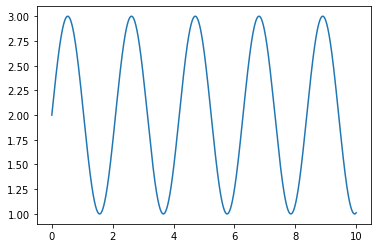

In [59]:
def excitation():
    return lambda t: 2+np.sin(3*t)

t = np.arange(0, 10, 0.001)
u = excitation()

plt.plot(t, u(t))
plt.show()

### Simulation with the conventional state-space model

The conventional state-space model:

$$ \begin{bmatrix} \dot{\theta}_1 \\ \dot{\theta}_2 \\ \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \underbrace{\begin{bmatrix} \boldsymbol{0} & \textbf{I} \\ -\textbf{M}^{-1}\textbf{K} & -\textbf{M}^{-1}\textbf{C} \end{bmatrix}}_{\textbf{A}} \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix} + \underbrace{\begin{bmatrix} \boldsymbol{0} \\ \textbf{M}^{-1} \end{bmatrix}}_{\textbf{B}} \underbrace{\begin{bmatrix} 0 \\ T \end{bmatrix}}_{\textbf{u}} $$

In [75]:
A, B = state_matrices(assembly)
C, D = np.eye(B.shape[0]), np.zeros(B.shape)

exc = u(t)
load = np.array([np.zeros(exc.shape), exc])

tout, yout, xout = lsim((A, B, C, D), load.T, t)

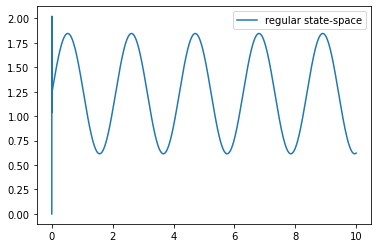

In [76]:
torques_lsim = 1.5e8*(yout[:,1]-yout[:,0])
plt.plot(tout, torques_lsim, label='regular state-space')
plt.legend()
plt.show()

### Simulation with the modified state-space model

(Note: This section is probably not relevant.)
The state vector of the conventional state-space model is replaced with the new one:

$$ \begin{bmatrix} \dot{\theta}_1 \\ \dot{\theta}_2 \\ \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \underbrace{\begin{bmatrix} \boldsymbol{0} & \textbf{I} \\ -\textbf{M}^{-1}\textbf{K} & -\textbf{M}^{-1}\textbf{C} \end{bmatrix}}_{\textbf{A}} \underbrace{\left( \begin{bmatrix} -k_1 & k_1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \right)^{-1}}_{X^{-1}} \begin{bmatrix} \tau_{12} \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix} + \underbrace{\begin{bmatrix} \boldsymbol{0} \\ \textbf{M}^{-1} \end{bmatrix}}_{\textbf{B}} \begin{bmatrix} 0 \\ T \end{bmatrix} $$

Additionally, using $ X $ as the observation matrix of the state-space model we get the shaft torque and nodal rotational speeds as output.

In [77]:
k1 = 1.5e8
X = np.array([[-k1, k1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
X_inv = X.T @ np.linalg.inv(X @ X.T)
print(X @ X_inv)

def f_mod(t, x):
    x_mod = X @ x
    return A @ (X_inv @ x_mod) + B @ np.array([0, u(t)])

dt = np.mean(np.diff(t))

sol_mod = solve_ivp(f_mod, (t[0], t[-1]), np.zeros(4), t_eval=t)

y = np.zeros(3)
for i in range(sol_mod.y.shape[1]):
    y = np.vstack((y, X @ sol_mod.y[:, i]))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


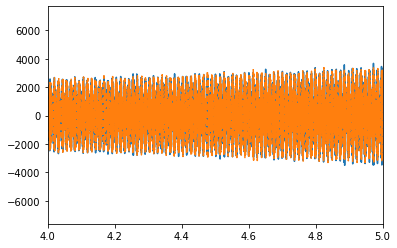

In [78]:
plt.plot(sol_mod.t, y[1:,0])
plt.plot(sol.t, k1*(sol.y[1,:] - sol.y[0,:]), '--')
plt.xlim(4,5)
plt.show()

# Simulation with the modified state matrix

Now we modify the state matrix $\textbf{A}$ with the matrix $\textbf{X}$:

$$ \begin{bmatrix} \dot{\tau}_{12} \\ \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \underbrace{\begin{bmatrix} -k_1 & k_1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \boldsymbol{0} & \textbf{I} \\ -\textbf{M}^{-1}\textbf{K} & -\textbf{M}^{-1}\textbf{C} \end{bmatrix}}_{\textbf{A}} \begin{bmatrix} \tau_{12} \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix} + \underbrace{\begin{bmatrix} \boldsymbol{0} \\ \textbf{M}^{-1} \end{bmatrix}}_{\textbf{B}} \begin{bmatrix} 0 \\ T \end{bmatrix}. $$

Recalling that

$$ \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta_2} \end{bmatrix} = \underbrace{\left( \begin{bmatrix} -k_1 & k_1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \right)^{-1}}_{X^{-1}} \begin{bmatrix} \tau_{12} \\ \dot{\theta}_1 \\ \dot{\theta_2} \end{bmatrix}, $$

we can define the modified state matrix as $ \textbf{A}_{\text{mod}} = \textbf{X} \textbf{A} \textbf{X}^{-1} $ to use shaft torque as a state. Additionally, the first row of $\textbf{B}$ is removed. Finally, we have

$$ \begin{bmatrix} \dot{\tau}_{12} \\ \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix}_{3 \times 1} = \begin{bmatrix} -k_1 & k_1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}_{3 \times 4} \begin{bmatrix} \boldsymbol{0} & \textbf{I} \\ -\textbf{M}^{-1}\textbf{K} & -\textbf{M}^{-1}\textbf{C} \end{bmatrix}_{4 \times 4} \left( \begin{bmatrix} -k_1 & k_1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \right)^{-1}_{4 \times 3} \begin{bmatrix} \tau_{12} \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix}_{3 \times 1} + \begin{bmatrix} \boldsymbol{0} \\ \textbf{M}^{-1} \end{bmatrix}_{3 \times 2} \begin{bmatrix} 0 \\ T \end{bmatrix}_{2 \times 1}. $$

In [79]:
def f_mod2(t, x):
    loading = B @ np.array([0, u(t)])
    loading = np.delete(loading, (0), axis=0)
    
    return (X @ A @ X_inv) @ x + loading

sol_mod2 = solve_ivp(f_mod2, (t[0], t[-1]), np.zeros(3), t_eval=t)

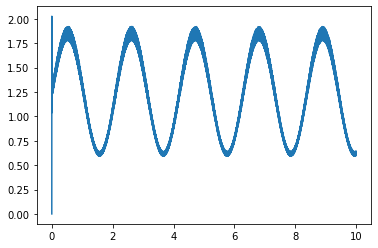

In [80]:
plt.plot(sol_mod2.t, sol_mod2.y[0,:], label='solve_ivp with modified state matrix')
# there might be some problem with the solve_ivp method

In [83]:
A_mod = X @ A @ X_inv
B_mod = np.delete(B, (0), axis=0)
C_mod = np.eye(B_mod.shape[0])
D_mod = np.zeros(B_mod.shape)

tout_mod, yout_mod, xout_mod = lsim((A_mod, B_mod, C_mod, D_mod), load.T, t)
print('Torque with the regular state-space equals the modified one:', np.allclose(yout_mod[:,0], torques_lsim, atol=1e-5))

Torque with the regular state-space equals the modified one: True


The shaft torque calculated with the regular state-space model and the modified model appear to be equal.

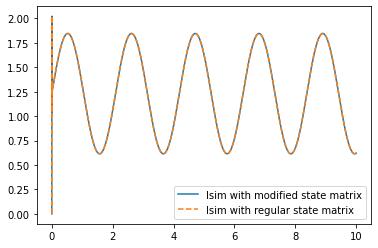

In [86]:
plt.plot(tout_mod, yout_mod[:,0], label='lsim with modified state matrix')
plt.plot(tout, torques_lsim, '--', label='lsim with regular state matrix')
plt.legend()
#plt.xlim(2.5,2.75)
#plt.ylim(1.84,1.85)
plt.show()

# Modified state-matrix for n-DOF drivetrain

In [ ]:
def propulsion_system():
    '''
    Parameters from: https://journals.sagepub.com/doi/full/10.1177/14759217211004232
    '''
    J1 = 1.347e4 # propeller
    J3 = 5.590e2
    J5 = 5.120e2
    J7 = 4.870e2
    J9 = 1.410e2
    J11 = 1.740e2
    J13 = 4.415e3 # motor
    
    k2 = 5.88e7
    k4 = 5.95e7
    k6 = 1.12e8
    k8 = 6.93e8
    k10 = 5.09e8
    k12 = 1.43e8
    damping = 180 # damping in steel_shafts
    propeller_damping = 120e3
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1, c=propeller_damping))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly

In [ ]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, C, K = assembly.M(), assembly.C(), assembly.K()  # Mass and stiffness matrices
    # C = assembly.C_modal(M, K, xi=0.02)  # Modal damping matrix, modal damping coefficient 0.02 used
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

In [ ]:
k_list = [5.88e7, 5.95e7, 1.12e8, 6.93e8, 5.09e8, 1.43e8]

In [ ]:
def X(k_values, ndof):
    """
    Used to transform the state-matrix to be compatible with shaft torque as a state.
    """
    rows = ndof-1
    cols = ndof
    if len(k_values) != rows:
        print("wrong amount of stiffness values / dofs")
        return
    
    X_up = np.zeros((rows, cols))
    X_down = np.eye(cols)
    Z_up = np.zeros(X_up.shape)
    Z_down = np.zeros(X_down.shape)
    
    for i in range(rows):
        X_up[i,i] = -k_values[i]
        X_up[i,i+1] = k_values[i]
    
    X_matrix = np.vstack([np.hstack([X_up, Z_up]), np.hstack([Z_down, X_down])])
    
    return X_matrix

In [ ]:
prop_sys = propulsion_system()
transformation = X(k_list, 7)